In [1]:
import sys
sys.path
sys.executable

'C:\\Users\\taoda\\Desktop\\maze\\mse-material-predict\\venv\\Scripts\\python.exe'

In [2]:
import numpy as np
import pandas as pd
import torch

In [3]:
demand = pd.read_csv('data/demand_train.csv', encoding='gbk')
stock = pd.read_csv('data/stock_train.csv', encoding='gbk')

In [4]:
demand['过账日期'] = pd.to_datetime(demand['过账日期'])

In [5]:
stock['过账日期'] = pd.to_datetime(stock['过账日期'])

In [6]:
demand.describe()

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类
count,1183595,1.183595e+06,1.183595e+06,1.183595e+06,1.183595e+06,1.183595e+06,1.183595e+06
mean,2019-07-18 09:37:17.450817792,1.958798e+00,2.006381e+03,1.072562e+03,5.002936e+03,3.002101e+03,4.009243e+03
min,2018-01-01 00:00:00,0.000000e+00,2.000000e+03,1.000000e+03,5.000000e+03,3.000000e+03,4.000000e+03
25%,2018-10-17 00:00:00,2.800000e-01,2.002000e+03,1.038000e+03,5.001000e+03,3.002000e+03,4.006000e+03
50%,2019-06-27 00:00:00,8.300000e-01,2.006000e+03,1.053000e+03,5.001000e+03,3.002000e+03,4.010000e+03
75%,2020-05-11 00:00:00,2.010000e+00,2.011000e+03,1.091000e+03,5.001000e+03,3.002000e+03,4.013000e+03
max,2020-11-24 00:00:00,8.868000e+01,2.015000e+03,1.297000e+03,5.012000e+03,3.004000e+03,4.023000e+03
std,NaN,3.016734e+00,4.934734e+00,5.195837e+01,3.641080e+00,5.131062e-01,5.127511e+00


In [7]:
demand = demand.groupby(['工厂编码', '过账日期', '物料编码', '物料品牌', '物料类型', '物料品类']).mean().reset_index()
stock = stock.groupby(['工厂编码', '过账日期', '物料编码', '物料品牌', '物料类型', '物料品类']).mean().reset_index()
demand, stock

(        工厂编码       过账日期  物料编码  物料品牌  物料类型  物料品类       需求量
 0       2000 2018-01-02  1027  5001  3002  4014  0.033333
 1       2000 2018-01-02  1029  5001  3002  4006  0.543333
 2       2000 2018-01-02  1031  5001  3002  4010  1.237857
 3       2000 2018-01-02  1034  5001  3002  4009  1.545000
 4       2000 2018-01-02  1037  5001  3002  4002  1.148571
 ...      ...        ...   ...   ...   ...   ...       ...
 248498  2015 2020-11-24  1083  5010  3002  4008  0.176000
 248499  2015 2020-11-24  1089  5010  3002  4013  0.668571
 248500  2015 2020-11-24  1090  5010  3002  4006  0.600000
 248501  2015 2020-11-24  1091  5010  3002  4010  2.831111
 248502  2015 2020-11-24  1252  5001  3002  4013  0.160000
 
 [248503 rows x 7 columns],
        工厂编码       过账日期  物料编码  物料品牌  物料类型  物料品类     库存量
 0      2000 2018-01-24  1001  5000  3002  4006    2.71
 1      2000 2018-01-24  1003  5000  3002  4005    6.84
 2      2000 2018-01-24  1014  5000  3002  4008    1.28
 3      2000 2018-01-24  1021  5000  3

In [8]:
time_to_int = lambda t: t.year * 12 + t.month - 1 + (1 if t.day > 24 else 0)
time_to_int(demand['过账日期'][0])

24216

In [9]:
demand['过账日期'] = demand['过账日期'].apply(time_to_int)
stock['过账日期'] = stock['过账日期'].apply(time_to_int)

In [10]:
demand = demand.drop(['物料类型', '物料品牌', '物料品类'], axis=1)

In [11]:
stock = stock.drop(['物料类型', '物料品牌', '物料品类'], axis=1)

In [12]:
#demand['库存量'] = 0
#stock['需求量'] = 0

In [13]:
data = pd.concat([demand, stock], axis=0)

In [14]:
data = data.groupby(['过账日期', '工厂编码', '物料编码']).sum().reset_index()

In [15]:
data.describe()

,过账日期,工厂编码,物料编码,需求量,库存量
count,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000
mean,24234.019201,2006.463630,1085.211140,32.868541,34.174574
std,9.581523,4.604702,69.969129,43.783638,83.884066
min,24216.000000,2000.000000,1000.000000,0.000000,0.000000
25%,24227.000000,2002.000000,1037.000000,5.092917,1.797500
50%,24234.000000,2006.000000,1054.000000,17.410090,8.170000
75%,24242.000000,2011.000000,1127.000000,41.570426,29.360000
max,24250.000000,2015.000000,1297.000000,514.890000,1270.690000


In [16]:
new_df = {'过账日期': data['过账日期'], '工厂编码': data['工厂编码']}

In [17]:
for i in range(data['物料编码'].min(), data['物料编码'].max() + 1):
    new_df['需求量-%d' % i] = (data['物料编码'] == i).apply(lambda x: 1 if x else 0) * data['需求量']

for i in range(data['物料编码'].min(), data['物料编码'].max() + 1):
    new_df['库存量-%d' % i] = (data['物料编码'] == i).apply(lambda x: 1 if x else 0) * data['库存量']
    pass

for i in range(data['工厂编码'].min(), data['工厂编码'].max() + 1):
    new_df['工厂编码-%d' % i] = (data['工厂编码'] == i).apply(lambda x: 1 if x else 0)
    pass

In [18]:
for i in range(0, 12):
    new_df['月份-%d' % i] = (data['过账日期'] % 12 == i).apply(lambda x: 1 if x else 0)
    pass

In [19]:
df = pd.DataFrame(new_df)

In [20]:
df.describe()

,过账日期,工厂编码,需求量-1000,需求量-1001,需求量-1002,需求量-1003,需求量-1004,需求量-1005,需求量-1006,需求量-1007,...,月份-2,月份-3,月份-4,月份-5,月份-6,月份-7,月份-8,月份-9,月份-10,月份-11
count,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,...,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000,15260.000000
mean,24234.019201,2006.463630,0.012819,0.201081,0.000851,0.967965,0.073122,0.088167,0.077924,0.084687,...,0.096068,0.094430,0.095872,0.096068,0.091284,0.086697,0.083814,0.079882,0.076737,0.048427
std,9.581523,4.604702,0.202027,2.164872,0.105155,9.835475,2.528168,3.317593,2.400122,2.332883,...,0.294694,0.292435,0.294425,0.294694,0.288023,0.281400,0.277118,0.271119,0.266182,0.214674
min,24216.000000,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24227.000000,2002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24234.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,24242.000000,2011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24250.000000,2015.000000,9.000000,64.686667,12.990000,318.175905,181.175000,197.795000,104.540000,177.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
df = df.groupby(['工厂编码', '过账日期']).sum().reset_index()

In [22]:
df = df.sort_values(['工厂编码', '过账日期'])

In [23]:
id_columns = ['工厂编码', '过账日期']

In [24]:
demand_and_stock = df.drop(id_columns, axis=1)

In [25]:
norm_demand_and_stock = demand_and_stock#(demand_and_stock - demand_and_stock.mean()) / demand_and_stock.std().apply(lambda x: 1 if x == 0 else x)

In [26]:
norm_df = pd.concat([df[id_columns], norm_demand_and_stock], axis=1)
norm_df.describe()

,工厂编码,过账日期,需求量-1000,需求量-1001,需求量-1002,需求量-1003,需求量-1004,需求量-1005,需求量-1006,需求量-1007,...,月份-2,月份-3,月份-4,月份-5,月份-6,月份-7,月份-8,月份-9,月份-10,月份-11
count,537.000000,537.000000,537.000000,537.000000,537.00000,537.000000,537.000000,537.000000,537.000000,537.000000,...,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,2007.264432,24233.256983,0.364292,5.714142,0.02419,27.506777,2.077921,2.505466,2.214367,2.406564,...,2.729981,2.683426,2.724395,2.729981,2.594041,2.463687,2.381750,2.270019,2.180633,1.376164
std,4.565945,10.152249,1.016688,10.092587,0.56056,44.972933,13.333613,17.529013,12.619600,12.220312,...,9.682829,9.567921,9.765842,9.721096,9.206736,8.669463,8.404727,7.987846,7.620607,5.974138
min,2000.000000,24216.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,24224.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2007.000000,24233.000000,0.000000,0.730000,0.00000,6.680000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2011.000000,24242.000000,0.150000,7.220000,0.00000,39.645000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2015.000000,24250.000000,9.000000,64.686667,12.99000,318.175905,181.175000,197.795000,104.540000,177.500000,...,63.000000,58.000000,63.000000,57.000000,55.000000,54.000000,53.000000,53.000000,52.000000,47.000000


In [27]:
class NormModel(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.norm = torch.nn.BatchNorm1d(input_size)

    def forward(self, x):
        return self.norm(x)

class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout = 0.5):
        super().__init__()
        
        self.dropout = torch.nn.Dropout(dropout)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.lstm = torch.nn.LSTM(input_size, hidden_size, 3, proj_size=output_size, batch_first=True, dropout=dropout, bidirectional=False)
        self.l2 = torch.nn.Linear(hidden_size, output_size)
        self.ch = None
        self.relu = torch.nn.Tanh()
        
    def reset(self):
        self.ch = None
    
    def forward(self, x):
        # x = self.dropout(x)
        # x = self.l1(x)
        # x = self.relu(x)
        # x = x.reshape(1, -1, self.hidden_size)
        x, self.ch = self.lstm(x, self.ch)
        x = x.reshape(-1, self.output_size)
        # x = self.relu(x)
        # x = self.l2(x)
        return x
             

In [28]:
feature_num = len(norm_df.columns) - 2
feature_num

624

In [29]:
net = RNN(feature_num, 2000, feature_num, 0.5)

In [30]:
#rand_data = torch.randn(2, feature_num)
#net.reset()
#net(rand_data)

In [31]:
loss_fn = torch.nn.L1Loss(reduction = 'sum')

In [32]:
a = torch.randn(2)
b = torch.zeros(2)
a, b, loss_fn(a, b)

(tensor([-0.4840, -0.2825]), tensor([0., 0.]), tensor(0.7665))

In [33]:
def to_data_set(dataset):
    ret = []
    for factory in range(dataset['工厂编码'].min(), dataset['工厂编码'].max() + 1):
        factory_ts = dataset[dataset['工厂编码'] == factory]
        factory_ts = factory_ts.drop(['工厂编码', '过账日期'], axis=1)
        factory_ts_np = torch.from_numpy(factory_ts.values.astype('float32'))
        k = factory_ts_np.shape[0]
        for start in range(0, 1):
            #if (k - 1 - start) >= 3:
            ret.append((factory_ts_np[start : k-1], factory_ts_np[start + 1 : k]))
    return ret

In [34]:
test_data_set = to_data_set(norm_df[norm_df['工厂编码'] <= 2002])
train_data_set = to_data_set(norm_df[norm_df['工厂编码'] > 2002])
len(train_data_set), len(test_data_set)

(13, 3)

In [35]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title='', clear=True):
    if clear:
        clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

def plot_predict(net, dataset, median):
    xs = [x[0].reshape(1, -1) for x in dataset]
    xs = torch.concat(xs, axis=0)
    ys = [x[1].reshape(1, -1) for x in dataset]
    ys = torch.concat(ys, axis=0)
    import random
    id = random.choice(range(ys.shape[1]))
    with torch.no_grad():
        linear_model.eval()
        predict = linear_model(xs)
        live_plot({'predict': predict[:, id].detach().numpy(), 'real': ys[:, id], 'median': [median[id] for i in range(ys.shape[0])]}, clear=False)

In [36]:
import random
def train_net(net, epoch):
    epochs = []
    train_loss = []
    test_loss = []

    optimizer = torch.optim.Adam(net.parameters())
    for e in range(0, epoch):
        print("Epoch ", e)
        epochs.append(e)

        # train model
        batch_size = 100
        net.train()
        random.shuffle(train_data_set)
        overall_mse = torch.tensor(0)
        overall_count = 0
        for batch_start in range(0, len(train_data_set), batch_size):
            optimizer.zero_grad()
            mse = torch.tensor(0)
            count = 0
            for train_item in train_data_set[batch_start:batch_start+batch_size]:
                net.reset()
                pred = net(train_item[0])
                actual = train_item[1]
                mse = mse + loss_fn(pred[2:], actual[2:])
                count += len(pred)  
            overall_mse = overall_mse + mse
            overall_count = overall_count + count
            print("Batch training MSE ", mse / count)
            mse = mse / count  
            mse.backward()
            optimizer.step()
        
        
        print("Overall training MSE ", overall_mse / overall_count)
        train_loss.append((overall_mse / overall_count).detach().numpy())

        #test model
        with torch.no_grad():
            net.eval()
            overall_mse = torch.tensor(0)
            overall_count = 0
            for batch_start in range(0, len(test_data_set), batch_size):
                mse = torch.tensor(0)
                count = 0
                for train_item in test_data_set[batch_start:batch_start+batch_size]:
                    net.reset()
                    pred = net(train_item[0])
                    actual = train_item[1]
                    mse = mse + loss_fn(pred[2:], actual[2:])
                    count += len(pred)
                overall_mse = overall_mse + mse
                overall_count = overall_count + count
                mse = mse / count
            
            print("Overall test MSE ", overall_mse / overall_count)
            test_loss.append((overall_mse / overall_count).detach().numpy())

        live_plot({'train': train_loss, 'test': test_loss}, title='loss')
        
    return epochs, train_loss, test_loss
        

In [37]:
total_params = sum(p.numel() for p in net.parameters())
total_params

36242624

In [38]:
#epochs, train_loss, test_loss = train_net(net, 500)

In [39]:
import random
def train_net(net, epoch, train_data_set, test_data_set, optimizer, loss_fn, median):
    epochs = []
    train_loss = []
    test_loss = []
    for e in range(0, epoch):
        #print("Epoch ", e)
        epochs.append(e)

        # train model
        batch_size = 1000
        net.train()
        random.shuffle(train_data_set)
        overall_mse = torch.tensor(0)
        overall_count = 0
        for batch_start in range(0, len(train_data_set), batch_size):
            optimizer.zero_grad()
            mse = torch.tensor(0)
            count = 0
            train_item = train_data_set[batch_start:batch_start+batch_size]
            xs = [x[0].reshape(1, -1) for x in train_item]
            xs = torch.concat(xs, axis=0)
            ys = [x[1].reshape(1, -1) for x in train_item]
            ys = torch.concat(ys, axis=0)
            if hasattr(net, 'reset') and callable(getattr(net, 'reset')):
                net.reset()
            pred = net(xs)
            actual = ys
            mse = mse + loss_fn(pred, actual) / pred.shape[1]
            count += pred.shape[0]             

            overall_mse = overall_mse + mse
            overall_count = overall_count + count
            #print("Batch training MSE ", mse / count)
            mse = mse / count  
            mse.backward()
            optimizer.step()
        
        
        #print("Overall training MSE ", overall_mse / overall_count)
        train_loss.append((overall_mse / overall_count).detach().numpy())

        #test model
        with torch.no_grad():
            net.eval()
            overall_mse = torch.tensor(0)
            overall_count = 0
            for batch_start in range(0, len(test_data_set), batch_size):
                mse = torch.tensor(0)
                count = 0
                train_item = test_data_set[batch_start:batch_start+batch_size]
                xs = [x[0].reshape(1, -1) for x in train_item]
                xs = torch.concat(xs, axis=0)
                ys = [x[1].reshape(1, -1) for x in train_item]
                ys = torch.concat(ys, axis=0)
                if hasattr(net, 'reset') and callable(getattr(net, 'reset')):
                    net.reset()
                pred = net(xs)
                actual = ys
                mse = mse + loss_fn(pred, actual) / pred.shape[1]
                count += pred.shape[0]       
                overall_mse = overall_mse + mse
                overall_count = overall_count + count
                mse = mse / count
            
            #print("Overall test MSE ", overall_mse / overall_count)
            test_loss.append((overall_mse / overall_count).detach().numpy())

        live_plot({'train': train_loss[-10:], 'test': test_loss[-10:]}, title='loss')
        plot_predict(net, test_data_set, median)
    return epochs, train_loss, test_loss
        

In [40]:
def to_data_set(dataset):
    ret = []

    for factory_id in range(2000, 2016):
        #print('factory_id', factory_id)
        factory_ts = dataset[dataset['工厂编码'] == factory_id]
        factory_ts = factory_ts.drop(['工厂编码', '过账日期'], axis=1)
        #factory_ts_no_stock = factory_ts.drop(['库存量-%d' % i for i in range(data['物料编码'].min(), data['物料编码'].max() + 1)], axis=1)
        factory_ts_no_stock = factory_ts.drop(['月份-%d' % i for i in range(0, 12)], axis=1)
        factory_ts_no_stock = factory_ts_no_stock.drop(['库存量-%d' % i for i in range(1000, 1298)], axis=1)
        factory_ts_no_stock = factory_ts_no_stock.drop(['工厂编码-%d' % i for i in range(2000, 2016)], axis=1)
        #print(factory_ts_no_stock.describe())
        #print(factory_ts_no_stock.describe())
        factory_ts_np = torch.from_numpy(factory_ts.values.astype('float32'))
        factory_ts_no_stock_np = torch.from_numpy(factory_ts_no_stock.values.astype('float32'))
        median = torch.from_numpy(factory_ts_no_stock.median().values)
        k = factory_ts_np.shape[0]
        #print(k)
        for i in range(0, k - 9):
            ret.append((factory_ts_np[i:i+6].reshape(1, -1), factory_ts_no_stock_np[i+6:i+9].reshape(1, -1)))
            #for i in range(0, k - 6):
            #    ret.append((factory_ts_np[i:i+3].reshape(1, -1), factory_ts_np[i+3:i+6].reshape(1, -1)))
    return ret, median

In [41]:
import random
factory_2000 = norm_df#norm_df[norm_df['工厂编码'] == 2000]
dataset, median = to_data_set(factory_2000)
train_size = len(dataset) // 4 * 3
train_data_set = dataset[: train_size]
test_data_set = dataset[train_size:]
len(dataset), len(train_data_set), len(test_data_set)

(393, 294, 99)

In [42]:
median.shape, dataset[0][0].shape, dataset[0][1].shape

(torch.Size([298]), torch.Size([1, 3744]), torch.Size([1, 894]))

In [43]:
loss_fn = torch.nn.L1Loss(reduction = 'sum')

In [52]:
# if we always return 0 for each predicts
xs = [x[0].reshape(1, -1) for x in test_data_set]
xs = torch.concat(xs, axis=0)
ys = [x[1].reshape(1, -1) for x in test_data_set]
ys = torch.concat(ys, axis=0)
zeros = torch.concat([median.reshape(1, -1) for i in range(ys.shape[0] * 3)], axis=0).reshape(ys.shape[0], -1)
print('Test avg loss', loss_fn(zeros, ys) / ys.shape[0] / ys.shape[1])

Test avg loss tensor(3.5851, dtype=torch.float64)


In [53]:
# if we always return 0 for each predicts
xs = [x[0].reshape(1, -1) for x in train_data_set]
xs = torch.concat(xs, axis=0)
ys = [x[1].reshape(1, -1) for x in train_data_set]
ys = torch.concat(ys, axis=0)
zeros = torch.concat([median.reshape(1, -1) for i in range(ys.shape[0] * 3)], axis=0).reshape(ys.shape[0], -1)
print('Train avg loss', loss_fn(zeros, ys) / ys.shape[0] / ys.shape[1])

Train avg loss tensor(3.6343, dtype=torch.float64)


In [54]:
feature_num = dataset[0][0].shape[1]
output_num = dataset[0][1].shape[1]
feature_num, output_num

(3744, 894)

In [55]:
class SimpleModel(torch.nn.Module):
    def __init__(self, size, layer):
        super().__init__()
        self.seq = nn.Sequential()
        for i in range(layer):
            self.seq.append(nn.Linear(size, size))
            self.seq.append(nn.ReLU())
        self.dropout = nn.Dropout()

    def forward(self, x):
        #x = self.dropout(x)
        return self.seq(x)

In [170]:
from torch import nn           


middle_size = 5000
linear_model = torch.nn.Sequential(
    nn.Dropout(),
    nn.Linear(feature_num, middle_size),
    nn.ReLU(),
)

for i in range(4):
    linear_model = linear_model.append(nn.Sequential(
        nn.Linear(middle_size, middle_size),
        nn.ReLU(),
    ))


linear_model = linear_model.append(
    nn.Linear(middle_size, output_num))


In [171]:
optimizer = torch.optim.Adam(linear_model.parameters())

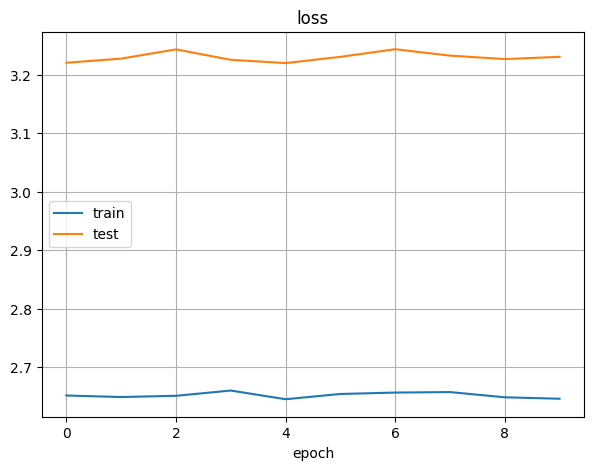

In [ ]:
epochs, train_loss, test_loss = train_net(linear_model, 200, train_data_set, test_data_set, optimizer, loss_fn, zeros[0])

In [83]:
train_loss[-1], test_loss[-1]

(array(2.38193, dtype=float32), array(3.15428, dtype=float32))

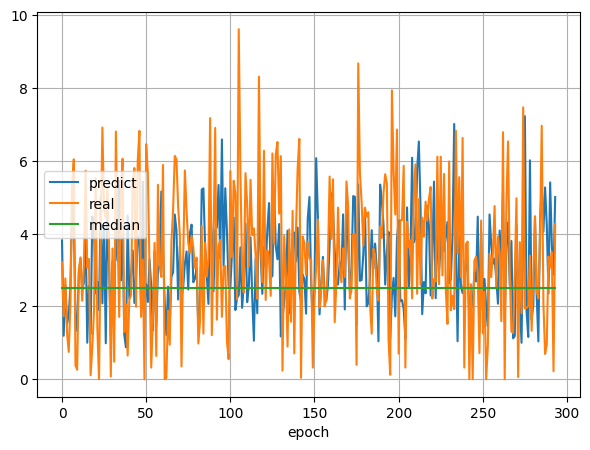

In [85]:
plot_predict(linear_model, train_data_set, zeros[0])

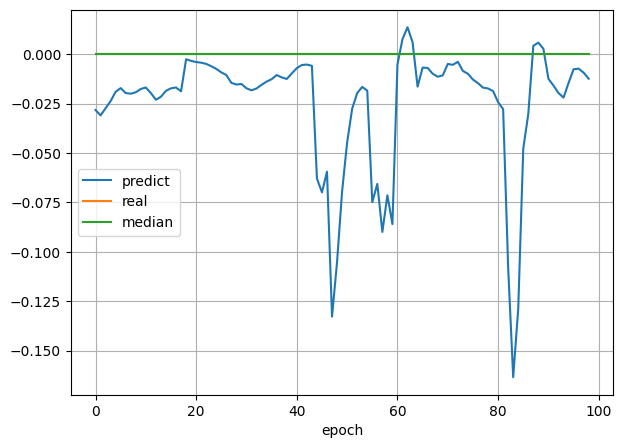

In [153]:
plot_predict(linear_model, test_data_set, zeros[0])

In [136]:
torch.save(linear_model, 'linear.pt')

In [162]:
factory_cols = []
demand_cols = []
p1_cols = []
p2_cols = []
p3_cols = []

linear_model.eval()
with torch.no_grad():
    for factory_id in range(2000, 2016):
        #print('factory_id', factory_id)
        factory_ts = norm_df[norm_df['工厂编码'] == factory_id]
        factory_ts = factory_ts.drop(['工厂编码', '过账日期'], axis=1)
        #factory_ts_no_stock = factory_ts.drop(['库存量-%d' % i for i in range(data['物料编码'].min(), data['物料编码'].max() + 1)], axis=1)
        factory_ts_no_stock = factory_ts.drop(['月份-%d' % i for i in range(0, 12)], axis=1)
        factory_ts_no_stock = factory_ts_no_stock.drop(['库存量-%d' % i for i in range(1000, 1298)], axis=1)
        factory_ts_no_stock = factory_ts_no_stock.drop(['工厂编码-%d' % i for i in range(2000, 2016)], axis=1)
        #print(factory_ts_no_stock.describe())
        #print(factory_ts_no_stock.describe())
        factory_ts_np = torch.from_numpy(factory_ts.values.astype('float32'))
        factory_ts_no_stock_np = torch.from_numpy(factory_ts_no_stock.values.astype('float32'))
        median = torch.from_numpy(factory_ts_no_stock.median().values)
        k = factory_ts_np.shape[0]
        xs = factory_ts_np[-6:].reshape(1, -1)
        ys = linear_model(xs)
        ys = ys.reshape(3, -1)
        for item_id in range(298):
            factory_cols.append(factory_id)
            demand_cols.append(str(item_id + 1000))
            p1_cols.append(float(ys[0][item_id]))
            p2_cols.append(float(ys[1][item_id]))
            p3_cols.append(float(ys[2][item_id]))

In [163]:
result = pd.DataFrame({'工厂编码': factory_cols, '物料编码': demand_cols, 'M+1月预测需求量': p1_cols, 'M+2月预测需求量': p2_cols, 'M+3月预测需求量': p3_cols})

In [164]:
for i in range(1, 4):
    result['M+%d月预测需求量' % i] = result['M+%d月预测需求量' % i].apply(lambda x: 0.0 if x < 0 else round(x, 2)) 

In [165]:
result

,工厂编码,物料编码,M+1月预测需求量,M+2月预测需求量,M+3月预测需求量
0,2000,1000,0.00,0.09,0.00
1,2000,1001,11.87,12.08,13.39
2,2000,1002,0.11,0.05,0.19
3,2000,1003,69.49,67.52,67.61
4,2000,1004,0.00,0.08,0.00
...,...,...,...,...,...
4763,2015,1293,0.03,0.00,0.00
4764,2015,1294,0.04,0.08,0.00
4765,2015,1295,0.00,0.07,0.03
4766,2015,1296,0.02,0.01,0.00


In [169]:
result.to_csv('结果.csv', index=False,encoding='gbk')

In [167]:
result.describe()

,工厂编码,M+1月预测需求量,M+2月预测需求量,M+3月预测需求量
count,4768.000000,4768.000000,4768.000000,4768.000000
mean,2007.500000,1.691313,1.719841,1.696799
std,4.610256,9.613868,9.783362,9.699477
min,2000.000000,0.000000,0.000000,0.000000
25%,2003.750000,0.000000,0.000000,0.000000
50%,2007.500000,0.010000,0.010000,0.000000
75%,2011.250000,0.060000,0.060000,0.060000
max,2015.000000,160.300000,164.730000,164.940000


In [168]:
total_params = sum(p.numel() for p in linear_model.parameters())
total_params

73205894